In [1]:
import mlflow
import optuna

from transforms import *
from utils import *
from plots import *
from pathlib import Path
import time
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

from optuna.trial import Trial, FrozenTrial
from optuna.study import Study

from typing import Optional, Dict


Testing on new data

In [2]:
df = pd.read_csv(f"../datasets/train.csv")

In [3]:
y_df = df[['is_attributed']]
X_df = df.drop(columns=['attributed_time', 'is_attributed'])

In [4]:
# X_df['click_time'] = pd.to_datetime(X_df['click_time'])

In [5]:
X_ldf, y_ldf = apply_transformations(X_df, y_df)

Applied transformation: add_hour_day_from_clicktime 
Using params {}
Error applying transformation: add_groupby_user_features 
Using params {'grouping_categories': [['ip', 'channel'], ['ip', 'device'], ['ip', 'os'], ['ip', 'app'], ['ip', 'day', 'hour'], ['app', 'channel'], ['ip', 'app', 'os'], ['ip', 'device', 'os', 'app']], 'grouping_functions': ['nunique', 'cumcount']}: Unable to allocate 19.3 GiB for an array with shape (14, 184903890) and data type int64


In [ ]:
X_ldf.to_csv("../datasets/X_full_transformed.csv")
y_ldf.to_csv("../datasets/y_full_transformed.csv")

KeyboardInterrupt: 

In [ ]:
logged_model = fr'..\mlartifacts\195007525428604903\ba343cbdaab14715b5cfaca1cf67477b\artifacts\model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [ ]:
preds = loaded_model.predict(X_ldf)

In [ ]:
auc_score = roc_auc_score(y_ldf, preds)
class_labels = (preds >= 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_ldf, class_labels).ravel()

In [ ]:
print(auc_score, tn, fp, fn, tp)

0.4127315810590817 643973 3967119 1544 9961


mlflow setup

In [2]:
tracking_uri = fr"http://127.0.0.1:8080"
metric_name = "auc"

In [3]:
mlflow.set_tracking_uri(tracking_uri)

In [4]:
X_us, y_us, test = init_datasets()

In [6]:
X_us = add_hour_day_from_clicktime(X_us)

In [7]:
grouping_categories = [
    # IP with every other base
    ['ip', 'channel'],
    ['ip', 'device'], 
    ['ip', 'os'],
    ['ip', 'app'],
    # IP and time features - must be done after adding time features
    ['ip', 'day', 'hour'],
    # Perhaps IP isn't as important
    ['app', 'channel'],
    # Triplet(s)
    ['ip', 'app', 'os'],
    # Quartet(s)
    ['ip', 'device', 'os', 'app']
    # Exclude all 5 together as these will be used for grouping
]
grouping_functions = ['nunique', 'cumcount']

In [8]:
X_us = add_groupby_user_features(X_us, grouping_categories=grouping_categories,
                                grouping_functions=grouping_functions)

In [9]:
X_us = add_next_click(X_us)

In [10]:
X_us.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'hour', 'day',
       'ip_channel_nunique', 'ip_channel_cumcount', 'ip_device_nunique',
       'ip_device_cumcount', 'ip_os_nunique', 'ip_os_cumcount',
       'ip_app_nunique', 'ip_app_cumcount', 'ip_day_hour_nunique',
       'ip_day_hour_cumcount', 'app_channel_nunique', 'app_channel_cumcount',
       'ip_app_os_nunique', 'ip_app_os_cumcount', 'ip_device_os_app_nunique',
       'ip_device_os_app_cumcount', 'user_hash', 'epoch_time', 'next_click'],
      dtype='object')

In [11]:
cols_to_bin = ['next_click'] # Just bin the one for now

In [12]:
X_us = log_bin_column(X_us, cols_to_bin)

c:\Users\Zade\Desktop\PythonStuff\adDetection\addetectionscripts\transforms.py:89: RuntimeWarning: divide by zero encountered in log2
  df[col] = np.log2(1 + df[col].values).astype(int)
c:\Users\Zade\Desktop\PythonStuff\adDetection\addetectionscripts\transforms.py:89: RuntimeWarning: invalid value encountered in log2
  df[col] = np.log2(1 + df[col].values).astype(int)
c:\Users\Zade\Desktop\PythonStuff\adDetection\addetectionscripts\transforms.py:89: RuntimeWarning: invalid value encountered in cast
  df[col] = np.log2(1 + df[col].values).astype(int)


In [13]:
X_us.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'hour', 'day',
       'ip_channel_nunique', 'ip_channel_cumcount', 'ip_device_nunique',
       'ip_device_cumcount', 'ip_os_nunique', 'ip_os_cumcount',
       'ip_app_nunique', 'ip_app_cumcount', 'ip_day_hour_nunique',
       'ip_day_hour_cumcount', 'app_channel_nunique', 'app_channel_cumcount',
       'ip_app_os_nunique', 'ip_app_os_cumcount', 'ip_device_os_app_nunique',
       'ip_device_os_app_cumcount', 'user_hash', 'epoch_time', 'next_click'],
      dtype='object')

In [14]:
# Drop the original click_time feature
X_us.drop(columns=['click_time'], inplace=True)

In [15]:
X_us.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'hour', 'day',
       'ip_channel_nunique', 'ip_channel_cumcount', 'ip_device_nunique',
       'ip_device_cumcount', 'ip_os_nunique', 'ip_os_cumcount',
       'ip_app_nunique', 'ip_app_cumcount', 'ip_day_hour_nunique',
       'ip_day_hour_cumcount', 'app_channel_nunique', 'app_channel_cumcount',
       'ip_app_os_nunique', 'ip_app_os_cumcount', 'ip_device_os_app_nunique',
       'ip_device_os_app_cumcount', 'user_hash', 'epoch_time', 'next_click'],
      dtype='object')

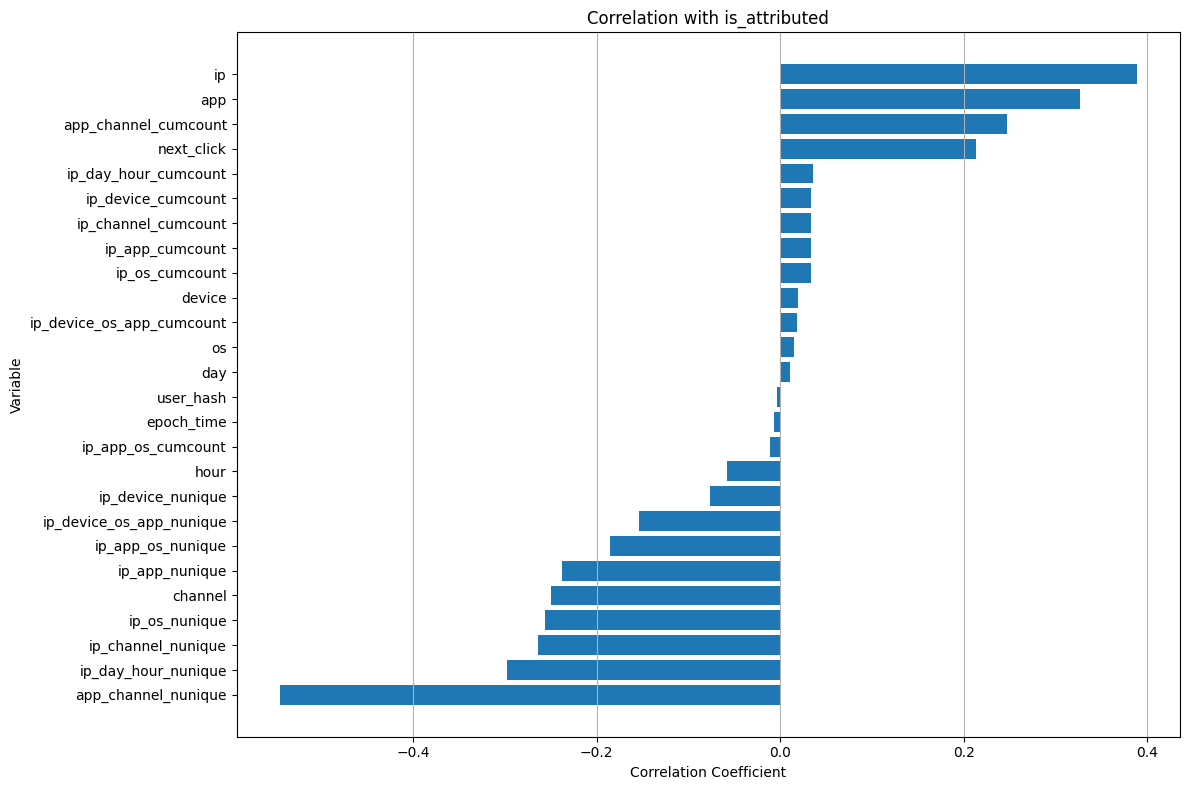

In [17]:
# correlation plot for mlflow
plot_correlation(X_us, y_us, target_col='is_attributed', save_path='test_corr_plot.png')

In [18]:
testing_plot = plot_correlation(X_us, y_us, target_col='is_attributed')

In [19]:
type(testing_plot)

matplotlib.figure.Figure

In [20]:
X_us.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'hour', 'day',
       'ip_channel_nunique', 'ip_channel_cumcount', 'ip_device_nunique',
       'ip_device_cumcount', 'ip_os_nunique', 'ip_os_cumcount',
       'ip_app_nunique', 'ip_app_cumcount', 'ip_day_hour_nunique',
       'ip_day_hour_cumcount', 'app_channel_nunique', 'app_channel_cumcount',
       'ip_app_os_nunique', 'ip_app_os_cumcount', 'ip_device_os_app_nunique',
       'ip_device_os_app_cumcount', 'user_hash', 'epoch_time', 'next_click'],
      dtype='object')

In [22]:
# mlflow server --host 127.0.0.1 --port 8080 
experiment_id = get_or_create_experiment("Attributed Class 2.")

In [23]:
experiment_id

'220429662594693156'

Do an XGBoost model first

In [24]:
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='mlflow-artifacts:/220429662594693156', creation_time=1716923831324, experiment_id='220429662594693156', last_update_time=1716923831324, lifecycle_stage='active', name='Attributed Class 2.', tags={}>

In [25]:
test_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_us, y_us, test_size=test_size, random_state=1233)

In [26]:
# Set to Dmatrix format for training speed
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

In [27]:
# Set optuna to log only errors
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [29]:
# Run name for mlflow logging
run_name = "first_attempt"

In [34]:
class OptunaXGBoost:
    def __init__(self, run_name: str, X_train: pd.DataFrame, y_train: pd.Series, X_valid: pd.DataFrame, y_valid: pd.Series,
                 feature_set_version: str, experiment_name: str = 'Attributed Class.', dtrain: Optional[xgb.DMatrix] = None,
                 dvalid: Optional[xgb.DMatrix] = None, num_trials: int = 50, tracking_uri: str = r'http://127.0.0.1:8080'):
        """
        Initialize the OptunaXGBoost class.

        Args:
            run_name (str): Name of the MLflow run.
            X_train (pd.DataFrame): Training input features.
            y_train (pd.Series): Training target variable.
            X_valid (pd.DataFrame): Validation input features.
            y_valid (pd.Series): Validation target variable.
            feature_set_version (str): Version of the feature set.
            experiment_name (str, optional): Name of the MLflow experiment. Defaults to 'Attributed Class.'.
            dtrain (Optional[xgb.DMatrix], optional): Training DMatrix. Defaults to None.
            dvalid (Optional[xgb.DMatrix], optional): Validation DMatrix. Defaults to None.
            num_trials (int, optional): Number of optimization trials. Defaults to 50.
            tracking_uri (str, optional): URI of the MLflow tracking server. Defaults to 'http://127.0.0.1:8080'.
        """
        self.run_name = run_name
        self.feature_set_version = feature_set_version
        self.num_trials = num_trials
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        if dtrain is None:
            self.dtrain = xgb.DMatrix(self.X_train, label=self.y_train)
        else:
            self.dtrain = dtrain
        if dvalid is None:
            self.dvalid = xgb.DMatrix(self.X_valid, label=self.y_valid)
        else:
            self.dvalid = dvalid
            
        self.tracking_uri = tracking_uri
        mlflow.set_tracking_uri(self.tracking_uri) ## Done in config when put to prod
        self.experiment_id = get_or_create_experiment(experiment_name)
        mlflow.set_experiment(experiment_id=self.experiment_id)


    def get_params(self, trial: Trial, param_config: Dict):
        params = {}
        for param, (ptype, *args) in param_config.items():
            if ptype == "categorical":
                params[param] = trial.suggest_categorical(param, args[0])
            elif ptype == "float":
                if len(args) == 3 and args[2] == "log":
                    params[param] = trial.suggest_float(param, args[0], args[1], log=True)
                else:
                    params[param] = trial.suggest_float(param, args[0], args[1])
            elif ptype == "int":
                params[param] = trial.suggest_int(param, args[0], args[1])
        return params


    def objective(self, trial: Trial, config: Dict) -> float:
        """
        Objective function for XGBoost hyperparameter optimization.

        Args:
            trial (optuna.trial.Trial): A trial object used to explore the search space.
            config (Dict): Dictonary containing the params for our trial

        Returns:
            float: The ROC AUC score on the validation set.
        """
        with mlflow.start_run(nested=True):
            params = self.get_params(trial, config.get('xgb_params', {}))
            
            bst = xgb.train(params, self.dtrain)
            preds = bst.predict(self.dvalid)
            auc_score = roc_auc_score(self.y_valid, preds)
            
            # Log to mlflow
            mlflow.log_params(params)
            mlflow.log_metric('auc', auc_score)
        return auc_score

    def best_trial_callback(self, study: Study, frozen_trial: FrozenTrial) -> None:
        """
        Logging callback that reports when a new trial iteration improves upon existing
        best trial values.

        Note: This callback is not intended for use in distributed computing systems such as Spark
        or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
        workers or agents.
        The race conditions with file system state management for distributed trials will render
        inconsistent values with this callback.

        Args:
            study (optuna.study.Study): The study object.
            frozen_trial (optuna.trial.FrozenTrial): The frozen trial object.

        Returns:
            None
        """

        winner = study.user_attrs.get("winner", None)

        if study.best_value and winner != study.best_value:
            study.set_user_attr("winner", study.best_value)
            if winner:
                improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
                print(
                    f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                    f"{improvement_percent: .4f}% improvement"
                )
            else:
                print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")
                
    def start_mlflow_runs(self, nested: bool = True) -> None:
        """
        Start MLflow runs for hyperparameter optimization.

        Args:
            nested (bool): Whether to have nested runs. Defaults to True.

        Returns:
            None
        """
        with mlflow.start_run(experiment_id=self.experiment_id, run_name=self.run_name, nested=nested):
            # Init Optuna
            study = optuna.create_study(direction='maximize') # Want to max our AUC
            
            # Optimize hparams
            study.optimize(self.objective, n_trials=self.num_trials, callbacks=[self.best_trial_callback])
            # Log best params/score
            mlflow.log_params(study.best_params)
            mlflow.log_metric('best_auc', study.best_value)
            
            # Set log tags
            mlflow.set_tags(
                tags={
                    'project': 'Ad Fraud Detection',
                    'optimizer_engine': 'Optuna',
                    'model_family': 'xgboost', 
                    'feature_set_version': self.feature_set_version
                }
            )
            
            # Log a fit model instance
            model = xgb.train(study.best_params, self.dtrain)
            
            # Log the correlation plot
            correlations = plot_correlation(self.X_train, self.y_train, target_col='is_attributed')
            mlflow.log_figure(figure=correlations, artifact_file='plot_correlation.png')
            
            # Log feature importance plot
            importances = plot_feature_importance(model, booster=study.best_params.get('booster'))
            mlflow.log_figure(figure=importances, artifact_file='feature_importances.png')
            
            artifact_path = 'model'
            
            mlflow.xgboost.log_model(
                xgb_model=model,
                artifact_path=artifact_path,
                input_example=self.X_train.iloc[[0]],
                model_format='ubj',
                metadata={'model_data_version':1}
            )
            
            # Get logged model uri for loading from artifact store
            model_uri = mlflow.get_artifact_uri(artifact_path)

In [48]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Hparams
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'booster': trial.suggest_categorical("booster", ["gbtree", "dart"]),
            'lambda': trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            'alpha': trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            'max_depth': trial.suggest_int("max_depth", 1, 5),
            'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
            'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        }
        
        bst = xgb.train(params, dtrain)
        preds = bst.predict(dvalid)
        auc_score = roc_auc_score(y_val, preds)
    
        # Log to mlflow
        mlflow.log_params(params)
        mlflow.log_metric('auc', auc_score)
    return auc_score

In [49]:
def champion_callback_local(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [51]:
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    # Init Optuna
    study = optuna.create_study(direction='maximize') # Want to max our AUC
    
    # Optimize hparams
    study.optimize(objective, n_trials=50, callbacks=[champion_callback_local])
    
    # Log best params/score
    mlflow.log_params(study.best_params)
    mlflow.log_metric('best_auc', study.best_value)
    
    # Set log tags
    mlflow.set_tags(
        tags={
            'project': 'Ad Fraud Detection',
            'optimizer_engine': 'Optuna',
            'model_family': 'xgboost', 
            'feature_set_version': 2
        }
    )
    
    # Log a fit model instance
    model = xgb.train(study.best_params, dtrain)
    
    # Log the correlation plot
    correlations = plot_correlation(X_us, y_us, target_col='is_attributed')
    mlflow.log_figure(figure=correlations, artifact_file='plot_correlation.png')
    
    # Log feature importance plot
    importances = plot_feature_importance(model, booster=study.best_params.get('booster'))
    mlflow.log_figure(figure=importances, artifact_file='feature_importances.png')
    
    artifact_path = 'model'
    
    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=X_train.iloc[[0]],
        model_format='ubj',
        metadata={'model_data_version':1}
    )
    
    # Get logged model uri for loading from artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)

Initial trial 0 achieved value: 0.933513392719326
Trial 3 achieved value: 0.9829992039700839 with  5.0342% improvement
Trial 6 achieved value: 0.9837393958321861 with  0.0752% improvement
Trial 12 achieved value: 0.9847031598970731 with  0.0979% improvement
Trial 16 achieved value: 0.9993300773322568 with  1.4637% improvement
Trial 18 achieved value: 0.9995605487807298 with  0.0231% improvement
Trial 42 achieved value: 0.999653506313402 with  0.0093% improvement


c:\Users\Zade\Desktop\PythonStuff\adDetection\.conda\lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
